In [1]:
pip install opencv-python pandas

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from tkinter import Tk, Label, Entry, Button, messagebox, Toplevel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from threading import Thread

# Global Variables
current_dir = os.getcwd()
database_path = os.path.join(current_dir, "employee_data.csv")
training_images_dir = os.path.join(current_dir, "training_images")
attendance_path = os.path.join(current_dir, "attendance.csv")
face_cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(face_cascade_path)

# Model Variables
model = None
labels = []
features = []

# Ensure Necessary Directories and Files Exist
def ensure_directories():
    if not os.path.exists(training_images_dir):
        os.makedirs(training_images_dir)
    if not os.path.exists(database_path):
        pd.DataFrame(columns=["Name", "Date of Birth", "Employee ID", "Phone", "Join Date"]).to_csv(database_path, index=False)
    if not os.path.exists(attendance_path):
        pd.DataFrame(columns=["Name", "Employee ID", "Timestamp"]).to_csv(attendance_path, index=False)

# Tkinter Interface for Employee Registration
def register_employee():
    name = name_entry.get()
    dob = dob_entry.get()
    emp_id = emp_id_entry.get()
    phone = phone_entry.get()
    join_date = join_date_entry.get()

    if not name or not dob or not emp_id or not phone or not join_date:
        messagebox.showerror("Error", "All fields are required!")
        return

    messagebox.showinfo("Info", "Look at the camera to capture your face. 1000+ images will be taken.")
    if capture_training_images(emp_id):
        save_employee_data(name, dob, emp_id, phone, join_date)
        messagebox.showinfo("Success", "Employee Registered Successfully!")
    else:
        messagebox.showerror("Error", "No face detected. Please try again.")

def capture_training_images(emp_id):
    cap = cv2.VideoCapture(0)
    count = 0
    emp_dir = os.path.join(training_images_dir, emp_id)
    if not os.path.exists(emp_dir):
        os.makedirs(emp_dir)

    while count < 1000:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(100, 100))

        for (x, y, w, h) in faces:
            face = gray[y:y+h, x:x+w]
            img_path = os.path.join(emp_dir, f"{count}.jpg")
            cv2.imwrite(img_path, face)
            count += 1
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

        cv2.imshow("Capture Training Images", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to quit capturing
            break

    cap.release()
    cv2.destroyAllWindows()
    return count >= 1000

def save_employee_data(name, dob, emp_id, phone, join_date):
    employee_data = pd.DataFrame([[name, dob, emp_id, phone, join_date]], 
                                 columns=["Name", "Date of Birth", "Employee ID", "Phone", "Join Date"])
    if os.path.exists(database_path):
        existing_data = pd.read_csv(database_path)
        employee_data = pd.concat([existing_data, employee_data], ignore_index=True)

    employee_data.to_csv(database_path, index=False)

# Train Model
def train_model():
    global model, labels, features
    labels, features = [], []

    target_size = (50, 50)  # Resize all images to 50x50 for consistency

    for emp_id in os.listdir(training_images_dir):
        emp_dir = os.path.join(training_images_dir, emp_id)
        for img_file in os.listdir(emp_dir):
            img_path = os.path.join(emp_dir, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_resized = cv2.resize(img, target_size)  # Resize image
                features.append(img_resized.flatten())  # Flatten resized image
                labels.append(emp_id)

    features = np.array(features)
    labels = np.array(labels)

    # Ensure at least two classes are present
    if len(np.unique(labels)) < 2:
        messagebox.showerror("Error", "At least two employees must be registered for training.")
        return

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    model = SVC(kernel='linear', probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    show_training_results(y_test, y_pred, accuracy)

def show_training_results(y_test, y_pred, accuracy):
    top = Toplevel(root)
    top.title("Training Results")

    Label(top, text=f"Accuracy: {accuracy:.2f}", font=("Arial", 16)).pack(pady=10)

    plt.figure(figsize=(8, 6))
    plt.bar(["Accuracy"], [accuracy], color='blue')
    plt.ylabel("Score")
    plt.title("Model Accuracy")
    plt.savefig("accuracy_graph.png")
    plt.show()

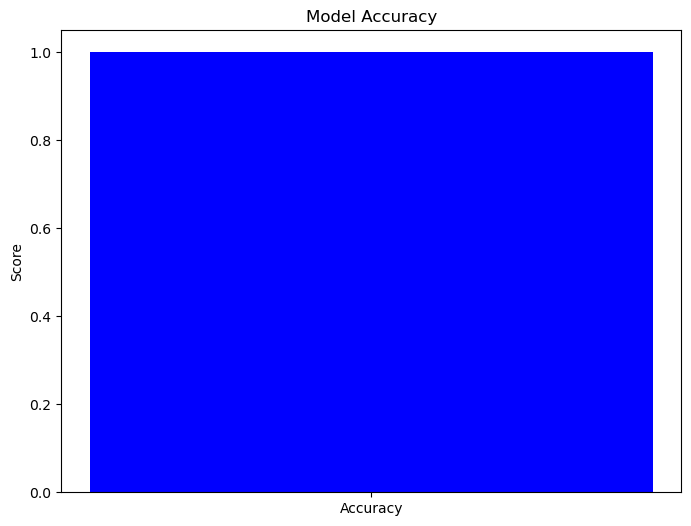

C:\Users\Aditya Chakravarty\AppData\Local\Temp\ipykernel_21260\3159848827.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  attendance = pd.concat([existing_attendance, attendance], ignore_index=True)


In [3]:
# Live Attendance
def mark_attendance():
    def stop_camera():
        global stop_flag
        stop_flag = True

    global stop_flag
    stop_flag = False

    target_size = (50, 50)  # Must match the size used during training

    cap = cv2.VideoCapture(0)
    stop_button = Button(root, text="Stop Camera", command=stop_camera)
    stop_button.grid(row=7, column=0, columnspan=2, pady=10)

    while not stop_flag:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(100, 100))

        for (x, y, w, h) in faces:
            face = gray[y:y+h, x:x+w]
            face_resized = cv2.resize(face, target_size)  # Resize to match training size
            face_flattened = face_resized.flatten().reshape(1, -1)  # Flatten and reshape for SVC

            if model is not None:
                pred = model.predict(face_flattened)[0]
                confidence = model.predict_proba(face_flattened)[0].max()
                if confidence > 0.7:  # Confidence threshold
                    record_attendance(pred)
                    cv2.putText(frame, f"ID: {pred} ({confidence:.2f})", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

        cv2.imshow("Live Attendance", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to quit
            break

    cap.release()
    cv2.destroyAllWindows()
    stop_button.destroy()

def record_attendance(emp_id):
    employee_data = pd.read_csv(database_path)
    employee = employee_data[employee_data["Employee ID"] == emp_id].iloc[0]
    attendance = pd.DataFrame([[employee["Name"], emp_id, pd.Timestamp.now()]],
                               columns=["Name", "Employee ID", "Timestamp"])
    if os.path.exists(attendance_path):
        existing_attendance = pd.read_csv(attendance_path)
        attendance = pd.concat([existing_attendance, attendance], ignore_index=True)

    attendance.to_csv(attendance_path, index=False)

# Main Tkinter Window
root = Tk()
root.title("Employee Attendance System")

# Ensure necessary directories and files exist
ensure_directories()

# Labels and Entries
Label(root, text="Name").grid(row=0, column=0, padx=10, pady=10)
name_entry = Entry(root)
name_entry.grid(row=0, column=1)

Label(root, text="Date of Birth").grid(row=1, column=0, padx=10, pady=10)
dob_entry = Entry(root)
dob_entry.grid(row=1, column=1)

Label(root, text="Employee ID").grid(row=2, column=0, padx=10, pady=10)
emp_id_entry = Entry(root)
emp_id_entry.grid(row=2, column=1)

Label(root, text="Phone").grid(row=3, column=0, padx=10, pady=10)
phone_entry = Entry(root)
phone_entry.grid(row=3, column=1)

Label(root, text="Joining Date").grid(row=4, column=0, padx=10, pady=10)
join_date_entry = Entry(root)
join_date_entry.grid(row=4, column=1)

# Buttons
Button(root, text="Register Employee", command=register_employee).grid(row=5, column=0, columnspan=2, pady=10)
Button(root, text="Train Model", command=train_model).grid(row=6, column=0, columnspan=2, pady=10)
Button(root, text="Mark Attendance", command=lambda: Thread(target=mark_attendance).start()).grid(row=7, column=0, columnspan=2, pady=10)

root.mainloop()